In [1]:
import torch
import torch.autograd.functional as F
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.icml2022())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'


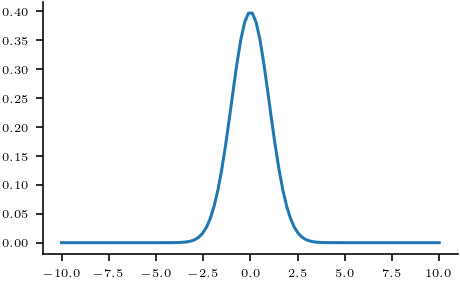

In [3]:
# Simple PDF approximation and assume it to be our prob function
p = torch.distributions.Normal(0, 1)

logp = lambda x: p.log_prob(x)

# Plot
plt.plot(x, p.log_prob(x).exp(), label='True PDF')
x = torch.linspace(-10, 10, 100)
plt.plot(x, p.log_prob(x).exp(), label='True PDF')




In [4]:
# Optimize logp using SGD
theta = torch.tensor(4.0, requires_grad=True)
optimizer = torch.optim.AdamW([theta], lr=0.01)

for i in range(2000):
    optimizer.zero_grad()
    loss = -logp(theta)
    if i % 100 == 0:
        print(i, theta.item(), loss.item())
    loss.backward()
    optimizer.step()


0 4.0 8.918938636779785
100 3.0124826431274414 5.4564642906188965
200 2.1752238273620605 3.284738063812256
300 1.497883915901184 2.040766716003418
400 0.9779170751571655 1.397099494934082
500 0.6023826003074646 1.1003708839416504
600 0.3488367199897766 0.9797820448875427
700 0.18942442536354065 0.9368793368339539
800 0.09626010805368423 0.9235715270042419
900 0.045690640807151794 0.9199823141098022
1000 0.02021404542028904 0.9191428422927856
1100 0.008314372971653938 0.9189730882644653
1200 0.003170008771121502 0.9189435243606567
1300 0.0011164519237354398 0.9189391136169434
1400 0.0003617757756728679 0.9189385771751404
1500 0.00010737218690337613 0.9189385175704956
1600 2.9038295906502753e-05 0.9189385175704956
1700 7.114796062523965e-06 0.9189385175704956
1800 1.5690019381509046e-06 0.9189385175704956
1900 3.091245162067935e-07 0.9189385175704956


In [7]:
theta_map = theta.detach()
theta_map

tensor(5.3954e-08)

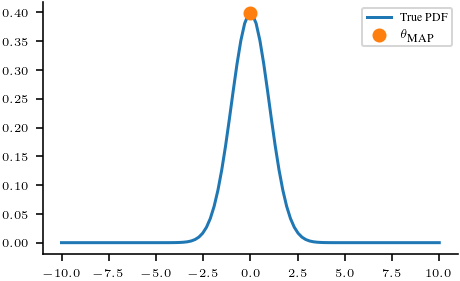

In [10]:
plt.plot(x, p.log_prob(x).exp(), label='True PDF')

# Plot theta_map point
plt.scatter(0, p.log_prob(theta_map).exp(), label=r'$\theta_\textrm{MAP}$', color='C1', zorder=10)
plt.legend()

In [11]:
hessian = F.hessian(logp, theta_map)
hessian

tensor(-1.)

In [12]:
scale= 1 / torch.sqrt(-hessian)
scale

tensor(1.)

In [13]:
# Approximate the PDF using the Laplace approximation
approx_p= dist.Normal(theta_map, scale)
approx_p

Normal(loc: 5.395416025066879e-08, scale: 1.0)

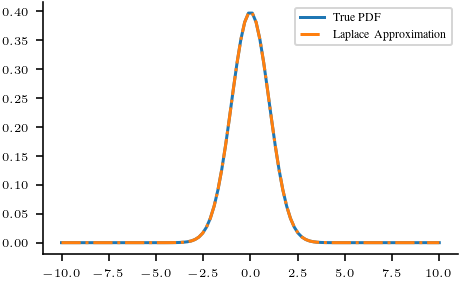

In [16]:
# Plot original PDF
x = torch.linspace(-10, 10, 100)
plt.plot(x, p.log_prob(x).exp(), label='True PDF')
# Plot Laplace approximation
plt.plot(x, approx_p.log_prob(x).exp(), label='Laplace Approximation', linestyle='-.')
plt.legend()

In [17]:
def laplace_approximation(logp, theta_init, lr=0.01, n_iter=2000):
    # Optimize logp using an optimizer
    theta = torch.tensor(theta_init, requires_grad=True)
    optimizer = torch.optim.AdamW([theta], lr=lr)
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -logp(theta)
        loss.backward()
        optimizer.step()
    theta_map = theta.detach()
    hessian = F.hessian(logp, theta_map)
    scale = 1 / torch.sqrt(-hessian)
    return dist.Normal(theta_map, scale)

In [18]:
def plot_orig_approx(logp, approx_p, min_x = -10, max_x = 10):
    # Plot original PDF
    x = torch.linspace(min_x, max_x, 500)
    plt.plot(x, p.log_prob(x).exp(), label='True PDF')
    # Plot Laplace approximation
    plt.plot(x, approx_p.log_prob(x).exp(), label='Laplace Approximation', linestyle='-.')
    plt.legend()

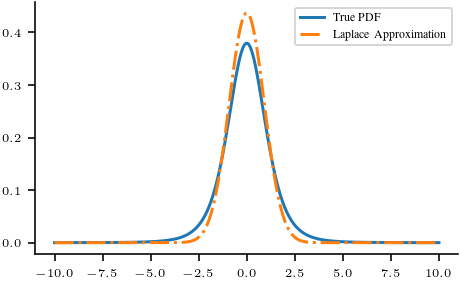

In [19]:
# Create a Student's t-distribution
p = dist.StudentT(5, 0, 1)
logp = lambda x: p.log_prob(x)

approx_p = laplace_approximation(logp, 4.0)
plot_orig_approx(logp, approx_p)

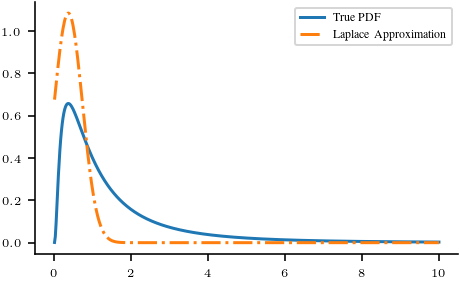

In [20]:
p = dist.LogNormal(0, 1)
logp = lambda x: p.log_prob(x)

approx_p = laplace_approximation(logp, 4.0)
plot_orig_approx(logp, approx_p, min_x=0.01)

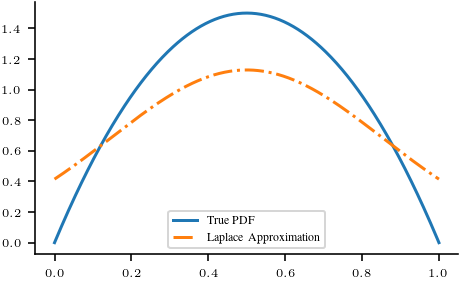

In [21]:
p = dist.Beta(2, 2)
logp = lambda x: p.log_prob(x)

approx_p = laplace_approximation(logp, 0.5)
plot_orig_approx(logp, approx_p, min_x=0, max_x=1)